# Exploración de medidas

In [53]:
import pandas as pd
from django.contrib.admin import display
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import os
from dotenv import load_dotenv
import locale

In [54]:
# Cargar variables de entorno
load_dotenv()
db_url = os.getenv("DATABASE_URL")

In [55]:
# Conexión con la base de datos
engine = create_engine(db_url)

In [56]:
# Definir estilo de gráficos
sns.set_style("whitegrid")

In [57]:
# Configurar el formato de moneda en español de México
locale.setlocale(locale.LC_ALL, 'es_MX.UTF-8')

'es_MX.UTF-8'

## Analisís de ventas

In [58]:
query_ventas_totales = """
SELECT SUM(total) AS ventas_totales FROM ventas;
"""
ventas_totales = pd.read_sql(query_ventas_totales, con=engine)
ventas_totales["ventas_totales"] = ventas_totales["ventas_totales"].apply(lambda x: f"${x:,.2f}")
display(ventas_totales)

,ventas_totales
0,"$1,195,772,981.08"


In [59]:
df_ventas = pd.read_sql("SELECT cantidad, precio_unitario, total FROM ventas", con=engine)
print("Análisis de ventas:")
print(df_ventas.describe())


Análisis de ventas:
            cantidad  precio_unitario          total
count  474086.000000    474086.000000  474086.000000
mean        9.986787       252.503596    2522.270181
std         5.478253       142.808080    2135.742600
min         1.000000         5.000000       5.000000
25%         5.000000       129.052500     763.640000
50%        10.000000       252.440000    1918.705000
75%        15.000000       376.360000    3816.087500
max        19.000000       500.000000    9499.350000


La media de ventas por transacción es $2,522.27$, con un precio unitario promedio de $252.50$.

In [72]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

outliers_ventas = detect_outliers_iqr(df_ventas, "total")
print("Outliers en ventas:")
print(outliers_ventas)

Outliers en ventas:
        cantidad  precio_unitario    total
31            19           485.64  9227.24
93            19           495.20  9408.84
99            19           491.86  9345.39
120           17           495.07  8416.26
440           18           486.61  8758.90
...          ...              ...      ...
473733        18           469.35  8448.27
473783        18           472.61  8506.98
473812        18           478.03  8604.59
473937        18           470.34  8466.04
474062        19           451.13  8571.52

[4938 rows x 3 columns]


Se detectaron muchas transacciones con ventas superiores a $8,000, lo que podría indicar compras al mayoreo o productos de alto valor.

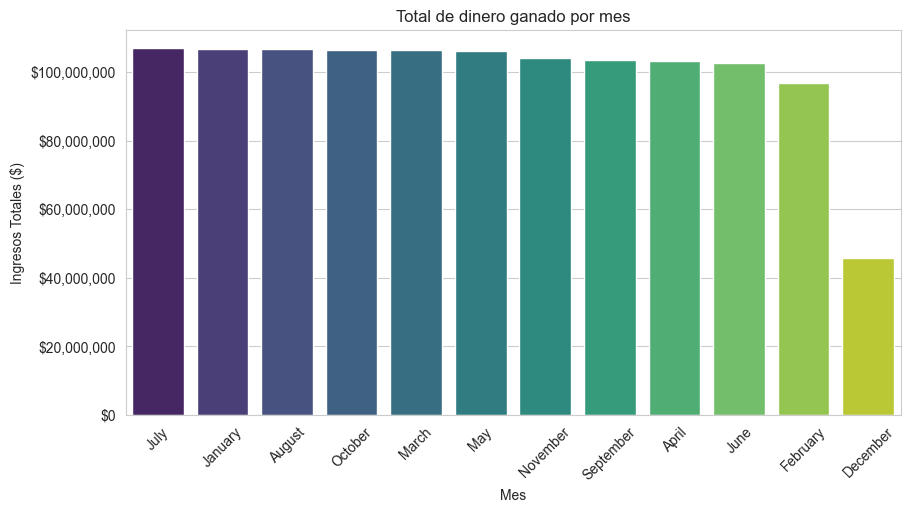

In [73]:
query_ingresos_mes = """
SELECT t.mes_nombre, SUM(v.total) AS ingresos_totales
FROM ventas v
JOIN tiempo t ON v.tiempo_id = t.tiempo_id
GROUP BY t.mes_nombre
ORDER BY ingresos_totales DESC;
"""
df_ingresos_mes = pd.read_sql(query_ingresos_mes, con=engine)
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_ingresos_mes, 
    x="mes_nombre", 
    hue="mes_nombre",
    legend=False,
    y="ingresos_totales", 
    palette="viridis"
)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

ax.set_title("Total de dinero ganado por mes")
ax.set_xlabel("Mes")
ax.set_ylabel("Ingresos Totales ($)")

plt.xticks(rotation=45)

plt.show()

La gráfica de ingresos totales por mes muestra el comportamiento de los ingresos de ventas durante los diferentes meses del año. Los datos presentan una tendencia en la que los primeros meses del año, como enero, febrero y marzo, tienen los ingresos más altos, superando los $100$  millones. Sin embargo, a medida que avanzan los meses, los ingresos totales disminuyen considerablemente, alcanzando su punto más bajo en diciembre, con un valor de $45.64$  millones.

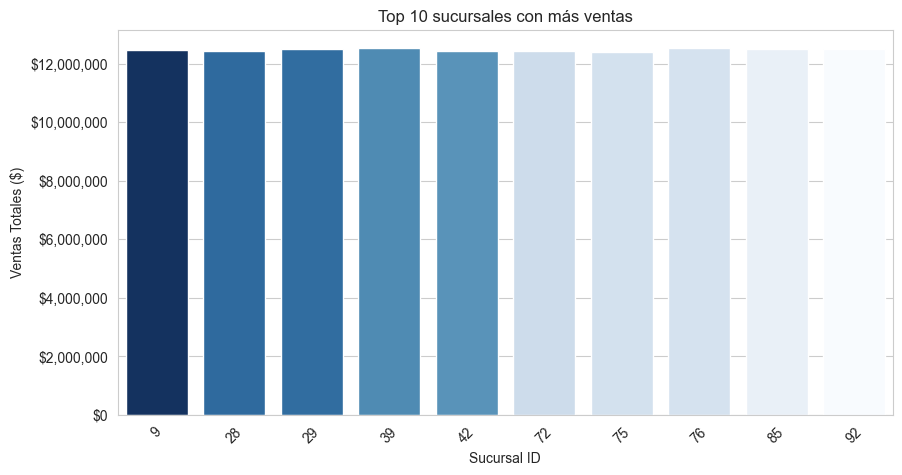

In [75]:
query_ingresos_sucursal = """
SELECT sucursal_id AS sucursal, SUM(total) AS ingresos_totales
FROM ventas 
GROUP BY sucursal
ORDER BY ingresos_totales DESC
LIMIT 10;
"""

df_ingresos_sucursal = pd.read_sql(query_ingresos_sucursal, con=engine)
plt.figure(figsize=(10, 5))
ax_top = sns.barplot(data=df_ingresos_sucursal, x="sucursal", hue="sucursal", legend=False, y="ingresos_totales", palette="Blues_r")

ax_top.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
ax_top.set_title("Top 10 sucursales con más ventas")
ax_top.set_xlabel("Sucursal ID")
ax_top.set_ylabel("Ventas Totales ($)")

plt.xticks(rotation=45)

plt.show()

La gráfica de ingresos por sucursal muestra las 10 sucursales con los mayores ingresos totales, con un rango de ingresos que va desde $12,423,473.90$ hasta $12,522,891.08$. Las sucursales están bastante equilibradas en términos de ingresos, ya que la diferencia entre la sucursal con el ingreso más alto y la de menor ingreso no es tan grande.

  tipo_venta  cantidad_ventas
0  Sin Envío           456567
1  Con Envío            17856


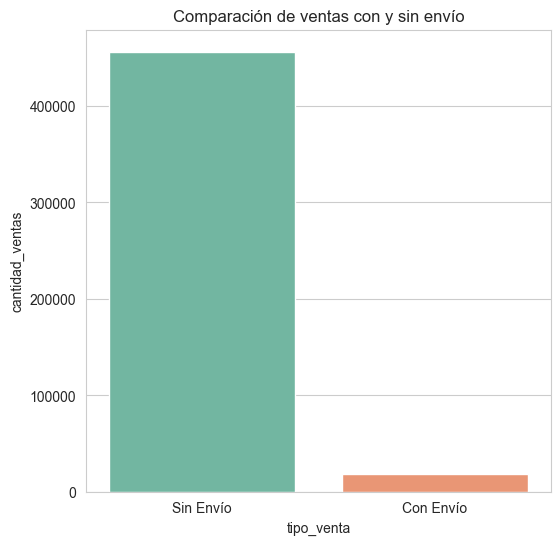

In [76]:
query_ventas_envios = """
SELECT 
    CASE 
        WHEN e.envio_id IS NULL THEN 'Sin Envío' 
        ELSE 'Con Envío' 
    END AS tipo_venta,
    COUNT(v.venta_id) AS cantidad_ventas
FROM ventas v
LEFT JOIN envios e ON v.venta_id = e.venta_id
GROUP BY tipo_venta;
"""
df_ventas_envios = pd.read_sql(query_ventas_envios, con=engine)
print(df_ventas_envios)
plt.figure(figsize=(6, 6))
sns.barplot(data=df_ventas_envios, x="tipo_venta", hue="tipo_venta", y="cantidad_ventas", palette="Set2")
plt.title("Comparación de ventas con y sin envío")
plt.show()

La gráfica de ventas con y sin envío muestra que el 96.3% de las ventas no requieren envío (456,567 ventas sin envío), mientras que solo un pequeño porcentaje (17,856 ventas con envío) implica un proceso de entrega.

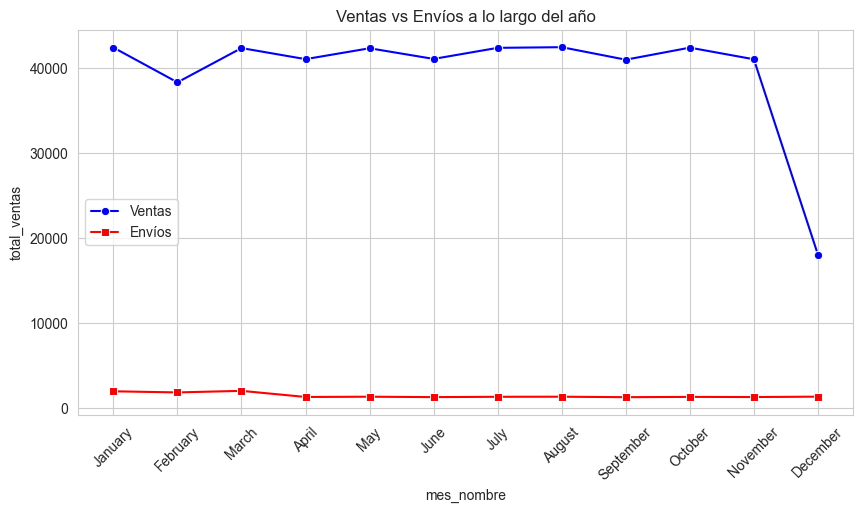

In [77]:
query_ventas_envios_tiempo = """
SELECT t.mes_nombre, 
       COUNT(DISTINCT v.venta_id) AS total_ventas,
       COUNT(DISTINCT e.envio_id) AS total_envios
FROM tiempo t
LEFT JOIN ventas v ON t.tiempo_id = v.tiempo_id
LEFT JOIN envios e ON t.tiempo_id = e.tiempo_id
GROUP BY t.mes_nombre
ORDER BY total_ventas DESC;
"""
df_ventas_envios_tiempo = pd.read_sql(query_ventas_envios_tiempo, con=engine)
meses_ordenados = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}

df_ventas_envios_tiempo['mes_num'] = df_ventas_envios_tiempo['mes_nombre'].map(meses_ordenados)

df_ventas_envios_tiempo = df_ventas_envios_tiempo.sort_values('mes_num')
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_ventas_envios_tiempo, x="mes_nombre", y="total_ventas", marker="o", label="Ventas", color="blue")
sns.lineplot(data=df_ventas_envios_tiempo, x="mes_nombre", y="total_envios", marker="s", label="Envíos", color="red")
plt.title("Ventas vs Envíos a lo largo del año")
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

La gráfica muestra la evolución mensual de las ventas y los envíos, con ambas métricas siguiendo patrones similares a lo largo del año. Las ventas se mantienen relativamente constantes, alcanzando su pico en agosto con 42,387 ventas, pero experimentan una caída significativa en diciembre, con solo 18,031 ventas. Por otro lado, los envíos muestran una tendencia a la baja a lo largo del año, siendo enero el mes con más envíos (1,989), y diciembre el mes con menos (1,359). A pesar de la disminución en las ventas hacia finales de año, los envíos siguen siendo relativamente constantes, sugiriendo que la desaceleración en las ventas podría estar relacionada con factores estacionales o cambios en el comportamiento del consumidor durante el último mes del año.

## Analisís de los clientes

In [78]:
df_clientes = pd.read_sql("SELECT edad FROM clientes", con=engine)
print("Análisis de Clientes:")
print(df_clientes.describe())

Análisis de Clientes:
               edad
count  49000.000000
mean      43.486571
std       15.009331
min       18.000000
25%       31.000000
50%       43.000000
75%       56.000000
max       98.000000


In [80]:
outliers_edad = detect_outliers_iqr(df_clientes, "edad")
print("Outliers en edades de clientes:")
print(outliers_edad)

Outliers en edades de clientes:
       edad
11370    98


El análisis de la edad de los clientes muestra que la edad promedio es de 43.5 años, con una desviación estándar de 15 años, lo que indica una amplia variabilidad en la edad de los clientes. La edad mínima es de 18 años y la máxima de 98 años, con un 25% de los clientes teniendo 31 años o menos, el 50% (mediana) teniendo 43 años, y el 75% alcanzando los 56 años. Se identificó un outlier con 98 años.

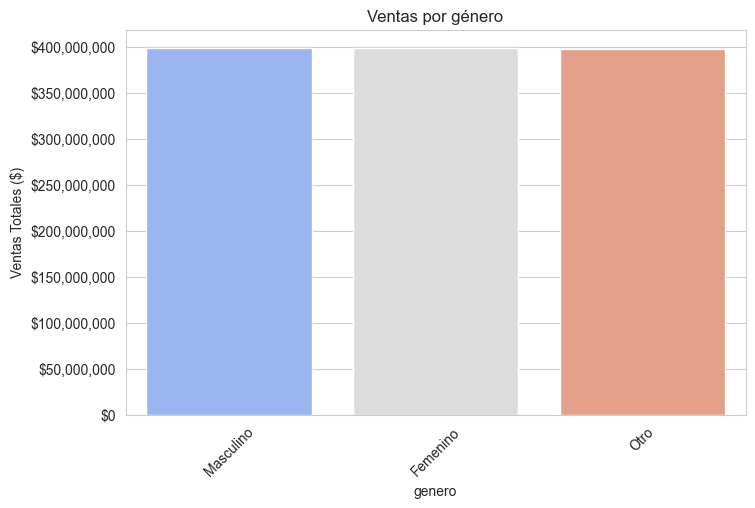

In [67]:
df_ventas_genero = pd.read_sql("""
    SELECT c.genero, AVG(c.edad) AS edad_promedio, SUM(v.total) AS total_ventas
    FROM ventas v
    JOIN clientes c ON v.cliente_id = c.cliente_id
    GROUP BY c.genero
    ORDER BY total_ventas DESC;
""", con=engine)

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df_ventas_genero, x="genero", hue="genero", y="total_ventas", palette="coolwarm")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.title("Ventas por género")
plt.ylabel("Ventas Totales ($)")
plt.tick_params(axis="x", rotation=45)
plt.show()


En cuanto a las ventas por género, se observó que las ventas totales son similares entre los géneros masculino, femenino y "otro", siendo las más altas para los géneros masculino y femenino, con cifras cercanas a $398$ millones de dólares. La edad promedio de los clientes masculinos es ligeramente menor (43.48 años) en comparación con las clientes femeninas (43.62 años), pero las diferencias en ventas totales entre géneros son pequeñas, sugiriendo que otros factores pueden influir en las compras más allá del género.

## Análisis de Productos

In [68]:
df_productos = pd.read_sql("SELECT precio_base FROM productos", con=engine)
print("Análisis de productos:")
print(df_productos.describe())

Análisis de productos:
       precio_base
count   980.000000
mean    265.384959
std     226.647895
min       5.380000
25%     125.095000
50%     258.365000
75%     379.057500
max    3141.900000


En el análisis de los precios de los productos, observamos un rango considerable de precios, con un precio base mínimo de $5.38$ y un precio máximo de $3141.90$. La media de los precios de los productos es de aproximadamente $265.38$, lo que indica que, en promedio, los productos tienen un precio moderado. Sin embargo, la alta desviación estándar de $226.65$ sugiere que existe una gran variabilidad en los precios de los productos. En cuanto a los cuartiles, el 25% de los productos tiene un precio inferior a $125.10$, el 50% (mediana) tiene un precio inferior a $258.37$, y el 75% de los productos tiene un precio inferior a $379.06$.

In [81]:
outliers_precios = detect_outliers_iqr(df_productos, "precio_base")
print("Outliers en precios de productos:")
print(outliers_precios)

Outliers en precios de productos:
     precio_base
40       2291.38
47       2801.88
121       799.95
150       814.77
402       991.34
523      3141.90
679      1255.71
718      2240.31
912      2595.85


Además, se identificaron varios valores atípicos (outliers) en los precios de los productos, los cuales son principalmente productos con precios significativamente más altos que el resto. Los outliers identificados incluyen precios como $2291.38$, $2801.88$ y $3141.90$, entre otros, que se encuentran muy por encima de la mayoría de los precios de los productos.

In [70]:
query_productos_vendidos = """
SELECT SUM(cantidad) AS productos_vendidos FROM ventas;
"""
productos_vendidos = pd.read_sql(query_productos_vendidos, con=engine)
productos_vendidos["productos_vendidos"] = productos_vendidos["productos_vendidos"].apply(lambda x: f"{x:,}")
display(productos_vendidos)

,productos_vendidos
0,"4,734,596.0"


En cuanto al total de productos vendidos, se registraron un total de 4,734,596 productos vendidos, lo que muestra una actividad considerable en las ventas.

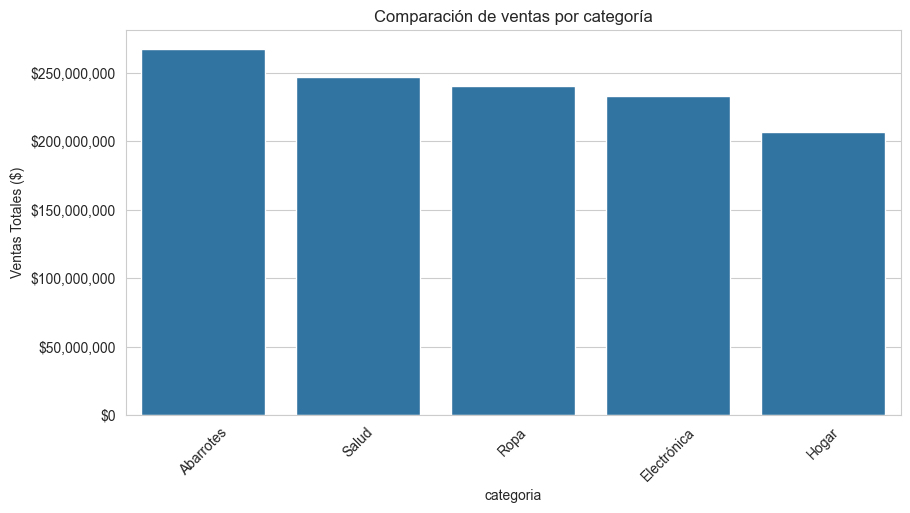

In [83]:
query_ventas_categoria = """
SELECT p.categoria, SUM(v.total) AS ventas_categoria
FROM ventas v
JOIN productos p ON v.producto_id = p.producto_id
GROUP BY p.categoria
ORDER BY ventas_categoria DESC;
"""
df_ventas_categoria = pd.read_sql(query_ventas_categoria, con=engine)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_ventas_categoria, 
    x="categoria", 
    y="ventas_categoria",
)

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.title("Comparación de ventas por categoría")
plt.ylabel("Ventas Totales ($)")
plt.tick_params(axis="x", rotation=45)
plt.show()

El análisis adicional de las ventas por categoría revela que las categorías más vendidas en términos de ingresos totales son "Abarrotes", seguida de "Salud", "Ropa", "Electrónica" y "Hogar", con los siguientes ingresos en cada categoría:

    Abarrotes: $267,923,200

    Salud: $247,418,000

    Ropa: $240,217,000

    Electrónica: $233,609,100

    Hogar: $206,605,700